In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


In [ ]:
import sys,os

sys.path.append('/home/alvinma/Desktop/mlfinlab')

sys.path.append('/home/alvinma/Desktop/mplfinance/src')


sys.path.append('/home/alvinma/Desktop/private-hft')
sys.path.append('../../ailabx-master')
from mlfinlab.filters import filters
from mlfinlab.labeling import labeling
# from mlfinlab.util import utils

In [ ]:
from utils.binance_load_data import *
from utils.mlfinlab_expand  import *
from utils.afml_backtest import *
from utils.clickhouse_utils  import *
from utils.analysis_data import *
from utils.twin_range_filter import *
from utils.kalman_filter import *
from utils.full_perona_malik import *
import imp
imp.reload(sys.modules['utils.binance_load_data'])
imp.reload(sys.modules['utils.mlfinlab_expand'])
imp.reload(sys.modules['utils.afml_backtest'])
imp.reload(sys.modules['utils.clickhouse_utils'])
imp.reload(sys.modules['utils.analysis_data'])
imp.reload(sys.modules['utils.twin_range_filter'])
imp.reload(sys.modules['utils.kalman_filter'])
imp.reload(sys.modules['utils.full_perona_malik'])
imp.reload(sys.modules['mlfinlab.features.fracdiff'])


In [ ]:
from mlfinlab.filters import filters
from mlfinlab.labeling import labeling


In [ ]:
from mlfinlab.sampling import concurrent
from mlfinlab.sampling import bootstrapping
from mlfinlab.util import multiprocess,get_daily_vol,get_minutes_vol,get_hours_vol

In [ ]:
import pyfolio as pf

In [ ]:
%matplotlib inline

In [ ]:
def get_test_dollar_bars2(database,password,start_date,end_date,table_name = 'binance_futures_um_trades_btcusdt_dollar_1_20230620042939'):
    # connect to clickhouse
    client =ClickHouseDB(host='localhost', port = 9000,
                                        user='default', 
                                        password = password,
                                        database=database
                                        )
    client.connect()

    data = client.get_dataframes(table_name,['*'],start_dt=start_date,end_dt=end_date)

    print(data.head(3))
    #only keep          open     high      low    close  volume    cum_dollar_value  cum_ticks  cum_buy_volume
    data = data[['timestamp','open','high','low','close','volume','cum_dollar_value','cum_ticks','cum_buy_volume','tick_num']]
    #rename columns to  open     high      low    close  cum_vol   cum_dollar  cum_ticks  cum_buy_volume
    data = data.rename(columns={'timestamp':'date_time','volume':'cum_vol','cum_dollar_value':'cum_dollar','cum_ticks':'cum_ticks','cum_buy_volume':'cum_buy_volume'})
    data.set_index('date_time',inplace=True)
    #sort by index
    data.sort_index(inplace=True)
    # data.index = pd.to_datetime(data['timestamp'])
    # data = data.drop('timestamp', axis=1)
    # close_prices = data['close']

    print(f"数据量：{len(data)} memory usage: {data.memory_usage().sum()/1024**2} MB shape: {data.shape} time range: {data.index.min()} - {data.index.max()}")
    return data

In [ ]:
import datetime as dt
from pytz import UTC
import getpass
from datetime import datetime

from utils.clickhouse_utils  import *



In [ ]:
def cover_agg_data_to_local_format(data):
    data.reset_index(inplace=True)
    data.rename(columns={'timestamp':'date_time','volume':'cum_vol','cum_dollar_value':'cum_dollar'},inplace=True)
    data.set_index('date_time',inplace=True)
    data = data[['open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks']]
    return data



In [ ]:
def load_btc():
    enable_load = True
    #check file  data.pkl exist
    if os.path.exists('data.pkl') and enable_load:
        data=pd.read_pickle('data.pkl')
        
    else:

        password=getpass.getpass("请输入ClickHouse的密码：")
        database=input("请输入ClickHouse的数据库名字：")
        start_date = datetime(2020, 1, 1, 0, 0, 0, 0,UTC)
        end_date = datetime.now(UTC)

        data = get_test_dollar_bars(database,password,start_date,end_date,table_name='binance_futures_um_trades_btcusdt_dollar_5_20230620094918')
        data.head()


        print(f"数据量：{len(data)} memory usage: {data.memory_usage().sum()/1024**2} MB shape: {data.shape} time range: {data.index.min()} - {data.index.max()}")
        data

        #if data.pkl exist

        #data save to pickle
        data.to_pickle('data.pkl')

    #prepare data to agg
    data.reset_index(inplace=True)
    #rename column date_time to timestamp
    data.rename(columns={'date_time':'timestamp','cum_vol':'volume','cum_dollar':'cum_dollar_value'},inplace=True)
    data['tick_num'] = data['cum_ticks'].cumsum()
    data.head()

    #agg

    data_raw = data.copy()
    data = dollar_bar_agg_mp(data_raw,scalar_step=5)
    close_prices = data['close']
    index_list = data.index.tolist()

    # 计算相邻两个datetime之间的时间间隔并保存到列表中
    time_intervals = [index_list[i + 1] - index_list[i] for i in range(len(index_list) - 1)]

    # 将时间间隔转换为秒数，方便后续分析
    time_intervals_seconds = [interval.total_seconds() for interval in time_intervals]

    # quantile
    print(pd.Series(time_intervals_seconds).quantile([0.1,0.2,0.3,0.4, 0.5,0.6,0.7,0.8, 0.9]))
    print(pd.Series(time_intervals_seconds).describe())
    print(f"shape: {data_raw.shape} time range: {data_raw.index.min()} - {data_raw.index.max()}")
    print(f"shape: {data.shape} time range: {data.index.min()} - {data.index.max()}")


    data = cover_agg_data_to_local_format(data)
    return data


    

In [ ]:
import datatable 
def load_eth(
    data_path = '/home/alvinma/Desktop/ailabx-master/data/cypto/ethusdt/ETHUSDT-FEATURES-20210101000112-20230803235959.csv'
):
    data = datatable.fread(data_path).to_pandas()
    print(f"shape {data.shape} time range: {data.index.min()} - {data.index.max()} memory usage: {data.memory_usage().sum()/1024**2} MB")
    data.set_index('date',inplace=True)
    print(data.columns.tolist())
    print_index_delta_describe(data)
    data = prepare_to_agg(data)
    data = dollar_bar_agg_mp(data,scalar_step=50)
    data = cover_agg_data_to_local_format(data)
    data = data[~data.index.duplicated(keep='first')]
    #sort by index
    data.sort_index(inplace=True)
    print(f"数据量：{len(data)} memory usage: {data.memory_usage().sum()/1024**2} MB shape: {data.shape} time range: {data.index.min()} - {data.index.max()}")
   
    return data



    

##### Define RSI 

In [ ]:
# Compute RSI
# def relative_strength_index(df, n):
#         """Calculate Relative Strength Index(RSI) for given data.
#         https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py
        
#         :param df: pandas.DataFrame
#         :param n: 
#         :return: pandas.DataFrame
#         """
#         i = 0
#         UpI = [0]
#         DoI = [0]
#         while i + 1 <= df.index[-1]:
#             UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
#             DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
#             if UpMove > DoMove and UpMove > 0:
#                 UpD = UpMove
#             else:
#                 UpD = 0
#             UpI.append(UpD)
#             if DoMove > UpMove and DoMove > 0:
#                 DoD = DoMove
#             else:
#                 DoD = 0
#             DoI.append(DoD)
#             i = i + 1
#         UpI = pd.Series(UpI)
#         DoI = pd.Series(DoI)
#         PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
#         NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
#         RSI = pd.Series(round(PosDI * 100. / (PosDI + NegDI)), name='RSI_' + str(n))
#         # df = df.join(RSI)
#         return RSI

# def get_rsi(data, window=14):
#     df = data.copy(deep=True).reset_index()
#     rsi = relative_strength_index(df, window)
#     rsi_df = pd.Series(data=rsi.values, index=data.index)
#     return rsi_df

# def bbands(close_prices, window, no_of_stdev):
#     rolling_mean = close_prices.ewm(span=window).mean()
#     rolling_std = close_prices.ewm(span=window).std()

#     upper_band = rolling_mean + (rolling_std * no_of_stdev)
#     lower_band = rolling_mean - (rolling_std * no_of_stdev)

#     return rolling_mean, upper_band, lower_band

def primary_bband_mode(data,window = 50,no_of_stdev=1.5):
    # compute bands
    print(f"window: {window} no_of_stdev: {no_of_stdev}")
    data['avg'], data['upper'], data['lower'] = bbands(data['close'], window, no_of_stdev=no_of_stdev)
    # data['upper'], data['avg'], data['lower'] = ta.BBANDS(data['close'], timeperiod=window, nbdevup=no_of_stdev, nbdevdn=no_of_stdev, matype=ta.MA_Type.WMA)
    
    # Compute RSI
    windows = [14]
    for window in windows:
        # rsi_df = get_rsi(data, window=window)
        # rsi_df = ta.RSI(data['close'],timeperiod=window)
        data['rsi_'+str(window)] = ta.RSI(data['close'],timeperiod=window) #pd.Series(data=rsi_df.values, index=data.index)
    # rsi_df = get_rsi(data, window=14)
    # data['rsi'] = pd.Series(data=rsi_df.values, index=data.index)

    # Drop the NaN values from our data set
    data.dropna(axis=0, how='any', inplace=True)

    # Compute sides
    data['side'] = np.nan 

    long_signals = (data['close'] <= data['lower']) 
    short_signals = (data['close'] >= data['upper']) 

    data.loc[long_signals, 'side'] = 1
    data.loc[short_signals, 'side'] = -1

    print(data.side.value_counts())

    # Remove Look ahead bias by lagging the signal
    data['side'] = data['side'].shift(1)
    data.dropna(axis=0, how='any', inplace=True)
    return data

def primary_trend_mode(data,fast_window = 20,slow_window = 50):
    # # compute moving averages
    data['fast_mavg'] = data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
    data['slow_mavg'] = data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()
    data.dropna(axis=0, how='any', inplace=True)
    # data.head()

    # # Compute sides
    # data['side'] = np.nan

    long_signals = data['fast_mavg'] >= data['slow_mavg'] 
    short_signals = data['fast_mavg'] < data['slow_mavg'] 
    # data.loc[long_signals, 'side'] = 1
    # data.loc[short_signals, 'side'] = -1

    # # Remove Look ahead biase by lagging the signal
    # data['side'] = data['side'].shift(1)

    data['side'] = np.nan 

    data.loc[long_signals, 'side'] = 1
    data.loc[short_signals, 'side'] = -1

    print(data.side.value_counts())

    # Remove Look ahead bias by lagging the signal
    data['side'] = data['side'].shift(1)
    data.dropna(axis=0, how='any', inplace=True)
    return data

def add_features(data,strategy = 'bband',**kwargs):
    strategies = {
        'trend':primary_trend_mode,
        'bband':primary_bband_mode
    }
    if strategy in strategies:
        return strategies[strategy](data,**kwargs)
    
    return data

def get_labels(data):
    # Compute daily volatility
    daily_vol = get_daily_vol(close=data['close'], lookback=100)

    # Apply Symmetric CUSUM Filter and get timestamps for events
    # Note: Only the CUSUM filter needs a point estimate for volatility
    # cusum_events = filters.cusum_filter(data['close'], threshold=daily_vol.mean() * 0.1)
    cusum_events = filters.cusum_filter(data['close'], threshold=0.0005)


    # Compute vertical barrier
    vertical_barriers = labeling.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_hours=10)
    pt_sl = [0, 1]
    min_ret = 0.0010
    side = data['side'] if 'side' in data.columns else None
    triple_barrier_events = labeling.get_events(close=data['close'],
                                                t_events=cusum_events,
                                                pt_sl=pt_sl,
                                                target=daily_vol,
                                                min_ret=min_ret,
                                                num_threads=2,
                                                vertical_barrier_times=vertical_barriers,
                                                side_prediction= side
                                                )
    triple_barrier_events.dropna(inplace=True)
    labels = labeling.get_bins(triple_barrier_events, data['close'])
    if 'side' in data.columns:
        print(side.value_counts(),labels.bin.value_counts(),labels.bin.value_counts()[1]/len(labels.bin))
    else:
        print(labels.bin.value_counts(),labels.bin.value_counts()[1]/len(labels.bin))
    return labels
def add_features2(raw_data):# MA_Type: 0=SMA, 1=EMA, 2=WMA, 3=DEMA, 4=TEMA, 5=TRIMA, 6=KAMA, 7
    # Log Returns
    raw_data['log_ret'] = np.log(raw_data['close']).diff()
    log_prices = np.log(data['close'].to_frame()).cumsum()
    raw_data['log_price_fd'] = fracdiff.frac_diff_ffd(log_prices, diff_amt=0.6, thresh=1e-5)
    # Momentum
    # windows = [1,2,3,5,8,13,21,34]
    windows = [1,2,3,4,5]
    
    for window in windows:
        raw_data['mom' + str(window)] = raw_data['close'].pct_change(periods=window)
       # autocorr
        # lags = [1,2,3,5,8,13,21,34]
        lags = [1]
        
        for lag in lags:
            raw_data['autocorr_' + str(window)+'_'+ str(lag)] = raw_data['log_ret'].rolling(window=window, min_periods=window, center=False).apply(lambda x: x.autocorr(lag=lag), raw=False)
    # raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
    # raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
    # raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
    # raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
    # raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

    # Volatility
    # window_stdevs = [30,50,80]
    window_stdevs = [50]
    
    for window_stdev in window_stdevs:
        raw_data['volatility'+ str(window)] = raw_data['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()
        
    # # Serial Correlation (Takes about 4 minutes)
    # window_autocorr = 50

    # raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
    # raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
    # raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
    # raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
    # raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

    # Get the various log -t returns
    raw_data['log_t1'] = raw_data['log_ret'].shift(1)
    raw_data['log_t2'] = raw_data['log_ret'].shift(2)
    raw_data['log_t3'] = raw_data['log_ret'].shift(3)
    raw_data['log_t4'] = raw_data['log_ret'].shift(4)
    raw_data['log_t5'] = raw_data['log_ret'].shift(5)

    # Add fast and slow moving averages
    fast_window = 7
    slow_window = 15

    raw_data['fast_mavg'] = raw_data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
    raw_data['slow_mavg'] = raw_data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()
    # Add Trending signals
    # raw_data['sma'] = np.nan
    raw_data['sma'] = 0
    long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
    short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']
    raw_data.loc[long_signals, 'sma'] = 1
    raw_data.loc[short_signals, 'sma'] = -1
    print(f"raw_data shape: {raw_data.shape} time range: {raw_data.index.min()} - {raw_data.index.max()}")
    # raw_data.dropna(inplace=True)
    print(f" after drop shape: {raw_data.shape} time range: {raw_data.index.min()} - {raw_data.index.max()}")
    
    return raw_data

def get_X_y(data,labels):
    # Get features that index is in labels
    X = data.loc[data.index.intersection(labels.index), :]
    # X = data.loc[labels.index, :]

    # Drop unwanted columns
    drop_cols = ["side",'avg', 'upper', 'lower', 'open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg']
    
    #get x columns that in drop_cols
    drop_cols = [x for x in drop_cols if x in X.columns]
    
    X.drop(drop_cols, axis=1, inplace=True)

    # y = labels['bin']
    y = labels.loc[X.index, 'bin']
    return X,y

def print_predict_metrics(y, y_pred,plot_cm = True):
    # 计算测试集上的准确率
    test_accuracy = accuracy_score(y, y_pred)
    print(f"Test Set Accuracy: {test_accuracy:.4f}")
    print(classification_report(y, y_pred))

    print("Confusion Matrix")
    print(confusion_matrix(y, y_pred))
    
    if plot_cm is True:
        cm = confusion_matrix(y, y_pred)
        # plot confusion matrix
        plt.figure()
        sns.heatmap(cm, annot=True, fmt='d')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.show()
        
def predict_metrics(clf,X,y,prob_idx=1,plot_cm = True):
    # data = load_eth()
    # data = add_features(data)
    # labels = get_labels(data)
    # data = add_features2(data)
    # X,y = get_X_y(data,labels)
    # X.shape,X.isna().sum().sum()
    # X_training_test = X
    # y_training_test = y
    # X_train, X_test, y_train, y_test = train_test_split(X_training_test, y_training_test, test_size=0.2, shuffle=False)
    # rf.fit(X_train, y_train)
    # 在测试集上进行推理（预测）
    y_pred = clf.predict(X)
    #probability
    prob = clf.predict_proba(X)
    
    #get df with columns y_true,y_pred,prob
    df = pd.DataFrame({'y_true':y,'y_pred':y_pred,'prob':prob[:,prob_idx]})
    
    print_predict_metrics(y, y_pred,plot_cm = plot_cm)
    
    # y_pred = pd.Series(data=y_pred,index=X.index)
    # prob = pd.Series(data=prob[:,prob_idx],index=X.index)
    
    # y_true.name = 'y_true'
    # y_pred.name = 'y_pred'
    # prob.name = 'prob'

    # df = pd.concat([y_true,y_pred,prob],axis=1)

    return df

    
# metrics_df = merge_metrics([train_metrics,test_matrics],data['close'],labels)



In [ ]:
def load_data(data_source='btc'):
    config={
        'btc':load_btc,
        'eth':load_eth
    }
    
    return config[data_source]()
data = load_data(data_source='eth')

In [ ]:
data = add_features(data,strategy='bband',window=50,no_of_stdev=1.5)
labels = get_labels(data)

In [ ]:
data.side.value_counts(),labels.bin.value_counts(),labels.bin.value_counts()[1]/len(labels.bin)

### Features

In [ ]:


data = add_features2(data)


In [ ]:
data.shape,data.isna().sum().to_dict()
# if the column has more than 15% nan value, drop it
data2 = data.dropna(thresh=int(len(data)*0.85), axis=1)
data2.shape,data2.isna().sum().to_dict()
data = data2.dropna(axis=0, how='any')
data.shape,data.isna().sum().sum()


In [ ]:
X_raw,y_raw = get_X_y(data,labels)
X_raw.shape,y_raw.isna().sum().sum()


In [ ]:
n_estimators = 100
max_depth = 5
random_state = 42
file_prefix = f"rf_{n_estimators}_{max_depth}_{random_state}"

X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2, shuffle=False)

rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state,oob_score=True,
                            class_weight='balanced_subsample', criterion='entropy', )
rf.fit(X_train, y_train)
metrics_df = predict_metrics(rf,X_test,y_test
                              ,prob_idx=0
                             ,plot_cm = False)
print(f"y_test shape: {y_test.shape} metrics_df shape: {metrics_df.shape}")



In [ ]:
test_matrics = predict_metrics(rf,X_test,y_test,plot_cm = False)
metrics_df = merge_metrics([test_matrics],data['close'],labels)

metrics_df = cal_strategy_ret(metrics_df,bet_size_config={
                'function': 'bet_size_probability',
                'step_size': 0.2,
                'num_classes': 2,
                'average_active': True,
                'true_prob_shift':0.15
              })



In [ ]:
plot_metrics_df(metrics_df)

In [604]:
metrics_df.head()

,y_true,y_pred,prob,close,t0,t1,ret,trgt,price_upper,price_lower,bin,side,bet_size,win_trade,lose_trades,strategy_ret,strategy_cum_absolute_ret,strategy_bet_ret,benchmark_ret
2023-01-20 18:01:19.476,0.0,0.0,0.359665,1596.45,2023-01-20 18:01:19.476,2023-01-21 23:43:11.110,-0.019115,0.038307,1596.45,1535.294166,0.0,-1.0,0.0,0,0,0.0,0.0,0.0,0.000000
2023-01-20 18:08:33.662,0.0,0.0,0.374167,1590.24,2023-01-20 18:08:33.662,2023-01-20 22:21:14.407,-0.038851,0.038224,1590.24,1529.454827,0.0,-1.0,0.0,0,0,0.0,0.0,0.0,-0.003890
2023-01-20 20:05:27.861,1.0,0.0,0.387012,1631.70,2023-01-20 20:05:27.861,2023-01-21 23:43:11.110,0.002544,0.038783,1631.70,1568.417141,1.0,-1.0,0.0,0,0,0.0,0.0,0.0,0.026072
2023-01-20 20:05:57.826,1.0,0.0,0.344898,1635.01,2023-01-20 20:05:57.826,2023-01-21 23:43:11.110,0.004577,0.039354,1635.01,1570.666069,1.0,-1.0,0.0,0,0,0.0,0.0,0.0,0.002029
2023-01-20 20:07:29.959,0.0,0.0,0.327400,1623.32,2023-01-20 20:07:29.959,2023-01-21 23:43:11.110,-0.002605,0.039654,1623.32,1558.948550,0.0,-1.0,0.0,0,0,0.0,0.0,0.0,-0.007150


In [ ]:
from utils.afml_backtest import *
import imp
imp.reload(sys.modules['utils.afml_backtest'])


back_test_report(metrics_df[['benchmark_ret','strategy_ret','strategy_bet_ret']],
                #  benchmark=metrics_df['benchmark_ret'],
                 compounded=True,fee=0.0008,html = False)


In [ ]:
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class GroupTimeSeriesSplit2(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_size : int, default=None
        Maximum size for a single training set.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import GroupTimeSeriesSplit
    >>> groups = np.array(['a', 'a', 'a', 'a', 'a', 'a',\
                           'b', 'b', 'b', 'b', 'b',\
                           'c', 'c', 'c', 'c',\
                           'd', 'd', 'd'])
    >>> gtss = GroupTimeSeriesSplit(n_splits=3)
    >>> for train_idx, test_idx in gtss.split(groups, groups=groups):
    ...     print("TRAIN:", train_idx, "TEST:", test_idx)
    ...     print("TRAIN GROUP:", groups[train_idx],\
                  "TEST GROUP:", groups[test_idx])
    TRAIN: [0, 1, 2, 3, 4, 5] TEST: [6, 7, 8, 9, 10]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a']\
    TEST GROUP: ['b' 'b' 'b' 'b' 'b']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] TEST: [11, 12, 13, 14]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b']\
    TEST GROUP: ['c' 'c' 'c' 'c']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]\
    TEST: [15, 16, 17]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c']\
    TEST GROUP: ['d' 'd' 'd']
    """
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_size=None
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end -
                                          self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]
            
            
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]

                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size

            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]


            if self.verbose > 0:
                    pass

            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [ ]:
X = X_raw.copy()
y = y_raw.copy()


In [ ]:
X['date_time'] = X.index
X.head()

In [ ]:
X['group'] = X.index.strftime('%Y%m%d').astype(int)
# #group by year_month
X.index =X['group']
X.head()

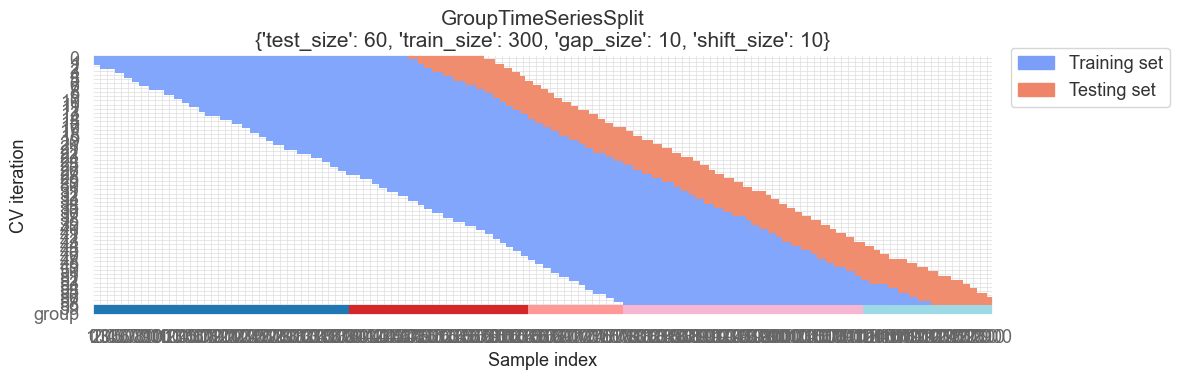

In [609]:
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
import sklearn.model_selection as ms

from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit,
    plot_splits,
    print_cv_info,
    print_split_info,
    
)



def get_GroupTimeSeriesSplit(X,y):
    groups = X['group'].values
    groups
    # cv_args = {"test_size": 20, "train_size": 300,'gap_size':10,'shift_size':10} #eth
    cv_args = {"test_size": 60, "train_size": 300,'gap_size':10,'shift_size':10}
    
    cv = GroupTimeSeriesSplit(**cv_args)
    # cv = PurgedGroupTimeSeriesSplit(n_splits=5,group_gap=14)
    plot_splits(X, y, groups, **cv_args)
    splits = list(cv.split(X, y, groups=groups)) 
    return cv,splits

# Function modified from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
def plot_cv_indices(cv, n_splits, X, y, date_col = None):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(1, 1, figsize = (11, 7))
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)


    # Formatting
    yticklabels = list(range(n_splits))
    
    if date_col is not None:
        tick_locations  = ax.get_xticks()
        tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-1])].astype(str).tolist() + [" "]

        tick_locations_str = [str(int(i)) for i in tick_locations]
        new_labels = ['\n\n'.join(x) for x in zip(list(tick_locations_str), tick_dates) ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(new_labels)
    
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.2, -.2])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    

from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, TimeSeriesSplit



def get_TimeSeriesSplit(X,y,n_splits):
    cv = TimeSeriesSplit(n_splits=n_splits)
   
    splits = list(cv.split(X))
    return cv,splits

enable_GTS = True
if enable_GTS is True:
    cv,splits = get_GroupTimeSeriesSplit(X,y)
else:
    n_splits = 4
    cv,splits = get_TimeSeriesSplit(X,y,n_splits)
    plot_cv_indices(cv, n_splits, X, y,date_col=None)


# print_split_info(X_train, y_train, groups, **cv_args)

In [ ]:
# train ,test
X.iloc[splits[0][0], :-2].shape,y.iloc[splits[0][1]].shape

In [631]:
splits[0][0]

array([ 112,  113,  114, ..., 4385, 4386, 4387])

In [610]:

n_estimators = 100
max_depth = 15
random_state = 42
file_prefix = f"rf_tss_5_walk_forward_{n_estimators}_{max_depth}_{random_state}"

rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state,oob_score=True,
                            class_weight='balanced_subsample', criterion='entropy', )

pred_metrics = pd.DataFrame()#(index=y.index,columns=['y_test','y_pred'])

for i, (train_idx, test_idx) in enumerate(splits):
    if i < len(splits)/2:
        continue
    seq_len = y.iloc[:train_idx[-1]].shape[0]
    print(f"{i} (train indices: {seq_len}, test indices: {len(test_idx)})")
    
    rf.fit(X.iloc[:train_idx[-1], :-2], y.iloc[:train_idx[-1]])
    # y_pred = rf.predict(X.iloc[test_idx, :-2])
    X_test = X.iloc[test_idx, :-2]
    y_test = y.iloc[test_idx]
    
    metrics = predict_metrics(rf,X_test,y_test,plot_cm = False)
    print(f"time range {X_test.index.min()} to {X_test.index.max()}")
    #if new index, add to pred_results
    
    same_index = metrics.index.intersection(pred_metrics.index)
    pred_metrics.loc[same_index,'y_pred'] = metrics.loc[same_index,'y_pred']
    
    new_index = metrics.index.difference(pred_metrics.index)
    pred_metrics = pd.concat([pred_metrics,metrics.loc[new_index,:]])

    

30 (train indices: 8214, test indices: 754)
Test Set Accuracy: 0.4775
              precision    recall  f1-score   support

           0       0.53      0.56      0.54       417
           1       0.41      0.37      0.39       337

    accuracy                           0.48       754
   macro avg       0.47      0.47      0.47       754
weighted avg       0.47      0.48      0.47       754

Confusion Matrix
[[234 183]
 [211 126]]
time range 20220222 to 20220510
31 (train indices: 8352, test indices: 712)
Test Set Accuracy: 0.4607
              precision    recall  f1-score   support

           0       0.48      0.55      0.51       366
           1       0.43      0.36      0.39       346

    accuracy                           0.46       712
   macro avg       0.46      0.46      0.45       712
weighted avg       0.46      0.46      0.46       712

Confusion Matrix
[[203 163]
 [221 125]]
time range 20220308 to 20220522
32 (train indices: 8526, test indices: 742)
Test Set Accuracy:

In [ ]:
pred_metrics
print_predict_metrics(pred_metrics.y_true, pred_metrics.y_pred,plot_cm = True)

In [621]:
pred_metrics.index.has_duplicates

False

,y_pred,y_true,prob
2022-02-22 03:08:33.288000+00:00,0,1.0,0.392633
2022-02-22 03:14:47.251000+00:00,0,1.0,0.472078
2022-02-22 03:20:31.600000+00:00,0,1.0,0.474133
2022-02-22 03:29:29.006000+00:00,0,1.0,0.422552
2022-02-23 08:27:48.586000+00:00,0,1.0,0.325667
...,...,...,...
2023-05-28 21:52:56.823000+00:00,1,1.0,0.547125
2023-05-28 22:02:07.658000+00:00,0,1.0,0.424949
2023-05-28 22:09:40.789000+00:00,0,1.0,0.395436
2023-05-28 22:13:27.717000+00:00,0,1.0,0.355466


In [618]:
type(pred_metrics.index[0]),type(data.index[0]),type(labels.index[0])

(pandas._libs.tslibs.timestamps.Timestamp,
 pandas._libs.tslibs.timestamps.Timestamp,
 pandas._libs.tslibs.timestamps.Timestamp)

In [628]:
intersection = pred_metrics.index.intersection(data.index).intersection(labels.index)
intersection

Index([], dtype='object')

In [630]:
pred_metrics.index

DatetimeIndex(['2022-02-22 03:08:33.288000+00:00',
               '2022-02-22 03:14:47.251000+00:00',
               '2022-02-22 03:20:31.600000+00:00',
               '2022-02-22 03:29:29.006000+00:00',
               '2022-02-23 08:27:48.586000+00:00',
               '2022-02-23 08:31:08.825000+00:00',
               '2022-02-23 08:41:10.625000+00:00',
               '2022-02-23 08:50:09.524000+00:00',
               '2022-02-23 09:11:54.742000+00:00',
               '2022-02-23 09:17:43.097000+00:00',
               ...
               '2023-05-28 18:23:06.029000+00:00',
               '2023-05-28 18:24:41.089000+00:00',
               '2023-05-28 18:27:53.550000+00:00',
               '2023-05-28 21:45:33.653000+00:00',
               '2023-05-28 21:46:45.421000+00:00',
               '2023-05-28 21:52:56.823000+00:00',
               '2023-05-28 22:02:07.658000+00:00',
               '2023-05-28 22:09:40.789000+00:00',
               '2023-05-28 22:13:27.717000+00:00',
            

In [629]:
data.index.intersection(labels.index)

DatetimeIndex(['2021-04-13 10:03:10.484000', '2021-04-13 15:06:08.925000',
               '2021-04-13 15:29:44.660000', '2021-04-13 15:51:02.278000',
               '2021-04-13 16:06:31.194000', '2021-04-13 16:21:41.664000',
               '2021-04-13 16:46:28.507000', '2021-04-13 17:57:14.711000',
               '2021-04-13 18:06:36.172000', '2021-04-13 18:24:58.394000',
               ...
               '2023-07-30 20:21:49.756000', '2023-07-30 20:56:17.619000',
               '2023-08-01 02:09:49.688000', '2023-08-01 02:10:10.598000',
               '2023-08-01 02:10:41.215000', '2023-08-01 02:11:59.310000',
               '2023-08-01 02:15:20.049000', '2023-08-01 02:22:35.147000',
               '2023-08-02 00:01:11.478000', '2023-08-02 00:22:19.933000'],
              dtype='datetime64[ns]', length=6393, freq=None)

In [623]:

def merge_metrics(metrics_list,price:pd.Series,labels:pd.DataFrame):
    df = pd.DataFrame()
    for i,metrics in enumerate(metrics_list):
        df = pd.concat([df,metrics],axis=0)
    df = pd.concat([df,price,labels],axis=1, join='inner')
    df.dropna(inplace=True)
    return df


metrics_df = merge_metrics([pred_metrics],data['close'],labels)


In [625]:
metrics_df

,y_pred,y_true,prob,close,t0,t1,ret,trgt,price_upper,price_lower,bin,side


In [624]:

metrics_df = cal_strategy_ret(metrics_df,bet_size_config={
                'function': 'bet_size_probability',
                'step_size': 0.2,
                'num_classes': 2,
                'average_active': True,
                'true_prob_shift':0.15
              })

metrics_df.head()

bet_size_config {'function': 'bet_size_probability', 'step_size': 0.2, 'num_classes': 2, 'average_active': True, 'true_prob_shift': 0.15}


IndexError: list index out of range

In [ ]:
plot_metrics_df(metrics_df)

In [ ]:
back_test_report(metrics_df[['benchmark_ret','strategy_ret','strategy_bet_ret']],
                #  benchmark=metrics_df['benchmark_ret'],
                 compounded=True,fee=0.0008,html = False)

In [ ]:
metrics_df.head()

In [ ]:
metrics_df = merge_metrics([pred_metrics],data['close'],labels)

metrics_df = cal_strategy_ret(metrics_df,bet_size_config={
                'function': 'bet_size_probability',
                'step_size': 0.2,
                'num_classes': 2,
                'average_active': True,
                'true_prob_shift':0.15
              })

plot_metrics_df(metrics_df)

In [ ]:
from mlfinlab.bet_sizing import (bet_size_probability, bet_size_dynamic, bet_size_budget, bet_size_reserve,
                                 confirm_and_cast_to_df, get_concurrent_sides, cdf_mixture, single_bet_size_mixed,
                                 M2N, centered_moment, raw_moment, most_likely_parameters)
from mlfinlab.bet_sizing.ch10_snippets import avg_active_signals, bet_size_power

In [ ]:
# pred_results['t0'] = labels.loc[pred_results.index,'t0']
# pred_results['t1'] = labels.loc[pred_results.index,'t1']
# pred_results['t1'] = labels.loc[pred_results.index,'t1']
pred_results.loc[pred_results.index,['t0','t1','bin','side','ret']] = labels.loc[pred_results.index,['t0','t1','bin','side','ret']]
pred_results['bet_size_prob'] = bet_size_probability(events=pred_results, prob=pred_results['prob'],
                                                     pred = pred_results['y_pred'],
                                                     step_size = 0.2,
                                                     average_active=True, num_classes=2)
# pred_results['signal'] = pred_results['bet_size_prob']
# avg_active_bet_sizes = avg_active_signals(pred_results, num_threads=8)
# pred_results['avg_active_bet_size'] = avg_active_bet_sizes
bet_size = pred_results['bet_size_prob']
print(len(bet_size),bet_size.index.min(),bet_size.index.max())


In [ ]:
trade_returns = get_trade_returns(labels,y_test,y_pred) - 0.0008
raw_ret = trade_returns.copy()
print(trade_returns.shape,trade_returns.index.min(),trade_returns.index.max())
trade_returns*=bet_size.loc[trade_returns.index]


print(f"Total return: {compute_total_return(raw_ret):.2f}")
print(f"Total return: {compute_total_return(trade_returns):.2f}")

# trade_returns['ret']*=bet_size.loc[trade_returns.index]
ret_df= pd.DataFrame({'trade_returns': trade_returns,'raw_ret':raw_ret})
ret_df
      

In [ ]:
ret_df.plot()

In [ ]:
 trade_returns

In [ ]:
trade_bet_size = bet_size.loc[trade_returns.index]
print(trade_bet_size.shape,trade_bet_size.index.min(),trade_bet_size.index.max())

In [ ]:
back_test(data,labels,y_test,y_pred,bet_size=bet_size,fee=0.0008,html=True,file_prefix=file_prefix)

In [ ]:
back_test(data,labels,y_test,y_pred,bet_size=None,fee=0.0008,html=True,file_prefix=file_prefix)

In [ ]:
pred_results['y_pred'][pred_results['y_pred']==1].shape

In [ ]:
pred_results['bet_size_prob'].hist(bins=100)

In [ ]:
pred_results['bet_size_prob'][pred_results['bet_size_prob']>0].hist(bins=100)

In [ ]:
from scipy.stats import norm, moment

from mlfinlab.bet_sizing.ch10_snippets import get_signal, avg_active_signals, discrete_signal
from mlfinlab.bet_sizing.ch10_snippets import get_w, get_target_pos, limit_price, bet_size
from mlfinlab.bet_sizing.ef3m import M2N, raw_moment, most_likely_parameters


signal_0 = get_signal(pred_results['prob'], 2, pred_results['y_pred'])
signal_0

In [ ]:
pred_results['prob'].hist(bins=100)

In [ ]:
pred_results[pred_results['y_pred'] == 1]['prob'].hist(bins=20)


In [ ]:
bet_sizes[bet_sizes>0].hist(bins=20)

In [ ]:
   # 1) Generate signals from multinomial classification (one-vs-rest).
# prob = pred_results['prob']
prob =np.linspace(0.5,1,10)
pred = 1
num_classes = 2
bet_sizes = (prob - 1/num_classes) / (prob * (1 - prob))**0.5
print(f"z: {bet_sizes}")
    # Allow for bet size to be returned with or without side.
if not isinstance(pred, type(None)):
        # signal = side * size
    bet_sizes = pred * (2 * norm.cdf(bet_sizes) - 1)
    print(f"1 m: {bet_sizes}")
else:
        # signal = size only
    bet_sizes = bet_sizes.apply(lambda s: 2 * norm.cdf(s) - 1)
    print(f"2 m: {bet_sizes}")
    
#plot bet_sizes ,x axis is prob
plt.figure()
plt.plot(prob,bet_sizes)
plt.xlabel('prob')
plt.ylabel('bet_sizes')
plt.show()

In [ ]:
signal_0[pred_results['y_pred']==1].shape,signal_0.shape

In [ ]:
signal_0[pred_results['y_pred']==1].sum()

In [ ]:
    events_0 = signal_0.to_frame('signal').join(events['t1'], how='left')
    if average_active:
        signal_1 = avg_active_signals(events_0, num_threads)
    else:
        signal_1 = events_0.signal

    if abs(step_size) > 0:
        signal_1 = discrete_signal(signal0=signal_1, step_size=abs(step_size))


In [ ]:
pred_results.head(20)

In [ ]:


print("The first 10 rows of the resulting DataFrame from Exercise 10.2:")
display(pred_results.head(10))
print("Summary statistics on the bet size columns:")
display(pred_results[['prob', 'bet_size_prob', 'avg_active_bet_size']].describe())

In [ ]:
events_2_classes = pd.DataFrame({'t1': pred_results.t1, 'prob': pred_results.prob})
events_2_classes = events_2_classes[events_2_classes.prob>0.5]

# 10.2(a) Compute bet sizes for ||X||=2
events_2_classes['bet_size_prob'] = bet_size_probability(events=events_2_classes, prob=events_2_classes['prob'], num_classes=2)

# 10.2(b) Assign 10,000 consecutive calendar days.
# See previous code cell.

# 10.2(c) Draw 10,000 random numbers from a uniform distribution.
# See previous code cell.

# 10.2(d) Create a pandas.Series object.
# See previous cell.

# Since this is a long-only strategy, all bet sides are '1'.
events_2_classes['side'] = pred_results.loc[events_2_classes.index, 'side']

# 10.2(e) Compute the average active bets (sizes).
# Calculate the concurrent long and short bets.
avg_active_bet_sizes = avg_active_signals(events_2_classes.rename(columns={'bet_size_prob': 'signal'}), num_threads=8)
events_2_classes['avg_active_bet_size'] = avg_active_bet_sizes

print("The first 10 rows of the resulting DataFrame from Exercise 10.2:")
display(events_2_classes.head(10))
print("Summary statistics on the bet size columns:")
display(events_2_classes[['prob', 'bet_size_prob', 'avg_active_bet_size']].describe())

In [ ]:
events_2_classes.shape,pred_results.shape

In [ ]:
pred_results.isna().sum().to_dict()

In [ ]:
avg_active_bet_sizes = avg_active_signals(pred_results, num_threads=8)
avg_active_bet_sizes.shape,avg_active_bet_sizes

In [ ]:
labels.head()

In [ ]:
pred_results

In [ ]:
file_prefix

In [ ]:

plot_trade_returns(data,labels,pred_results.y_test,pred_results.y_pred,pred_results.prob,fee=0.0008)


In [ ]:
plot_trade_daily_count(data,labels,pred_results.y_test,pred_results.y_pred)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42,oob_score=True,
                            class_weight='balanced_subsample', criterion='entropy', )

rf1 = RandomForestClassifier(n_estimators=100, random_state=1,oob_score=True,
                            class_weight='balanced_subsample', criterion='entropy', )
rf2 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=2,oob_score=True,
                            class_weight='balanced_subsample', criterion='entropy', )
rf3 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=3,oob_score=True,
                            class_weight='balanced_subsample', criterion='entropy', )
# rf4 = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=4,oob_score=True,
#                             class_weight='balanced_subsample', criterion='entropy', )
# rf5 = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=5,oob_score=True,
#                             class_weight='balanced_subsample', criterion='entropy', )
voting_clf = VotingClassifier(estimators=[('rf1', rf1), ('rf2', rf2), ('rf3', rf3),
                                          # ('rf4', rf4),
                                        #   ('rf5', rf5),
                                          
                                          ], voting='soft')


In [ ]:
# 使用 K-Fold 进行训练和验证
kf = KFold(n_splits=3, shuffle=False)
fold_accuracies = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # 训练投票融合模型
    voting_clf.fit(X_train_fold, y_train_fold)
    
    # 在验证集上进行推理（预测）
    y_pred_fold = voting_clf.predict(X_val_fold)
    
    # 计算验证集上的准确率并存储
    fold_accuracy = accuracy_score(y_val_fold, y_pred_fold)
    fold_accuracies.append(fold_accuracy)

# 计算 K-Fold 交叉验证的平均准确率
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"Mean Cross-Validation Accuracy: {mean_accuracy:.4f} fold_accuracies:{fold_accuracies}")
vot_y_pred = predict_metrics(voting_clf,X_test,y_test)


In [ ]:
voting_clf.fit(X_train, y_train)
vot_y_pred,_ = predict_metrics(voting_clf,X_test,y_test)

In [ ]:
rf.fit(X_train, y_train)
rf_y_pred = predict_metrics(rf,X_test,y_test)

In [ ]:
from utils.afml_backtest import *
import imp
imp.reload(sys.modules['utils.afml_backtest']) 


# trade_returns = get_trade_returns(labels,y_test,y_test)
# total_return = compute_total_return(trade_returns)
# print(f"Total return: {total_return:.2f}")
back_test(data,labels,y_test,rf_y_pred,fee=0.0008,html=True,file_prefix='rf')
back_test(data,labels,y_test,vot_y_pred,fee=0.0008,html=True,file_prefix='vot')





In [ ]:
from utils.afml_backtest import *
import imp
imp.reload(sys.modules['utils.afml_backtest']) 

benchmarks = []
rf_daily_rets,benchmark_rets = get_trade_daily_returns_benchmark(data,labels,y_test,rf_y_pred,fee=0.0008)
benchmarks.append((rf_daily_rets,benchmark_rets,'rf'))
vot_daily_rets,benchmark_rets = get_trade_daily_returns_benchmark(data,labels,y_test,vot_y_pred,fee=0.0008)
benchmarks.append((vot_daily_rets,benchmark_rets,'vot'))


qs.reports.html(rf_daily_rets, 
                    benchmark=vot_daily_rets,
                    periods_per_year=365,
                    strategy_title = "rf",
                    benchmark_title = "vot",
                    output = f"rf-vot.html"
                    # title=f'meta-label-trend 2*fee {fee*100}% {datetime.now()}'
                    )


In [ ]:
plot_trade_returns(data,labels,y_test,rf_y_pred,fee=0.0008)
plot_trade_returns(data,labels,y_test,vot_y_pred,fee=0.0008)

In [ ]:
len(rf_y_pred),rf_y_pred

In [ ]:
plot_trade_returns(data,labels,y_test,rf_y_pred,fee=0.0008)

plot_trade_daily_count(data,labels,y_test,y_pred)

In [ ]:

plot_trade_daily_count(data,labels,y_test,y_pred)

In [ ]:
if True:    
    df = data.loc[y_test.index.min():y_test.index.max(), :][['open', 'high', 'low', 'close']]
    label_test = labels.loc[y_test.index, :]
    df.loc[label_test.index,['t1','bin','side','ret']] = label_test[['t1','bin','side','ret']]
    df.loc[y_test.index, 'y_test'] = y_test
    df.loc[y_test.index, 'y_pred'] = y_pred
    df.loc[]
trade_df = df.loc[df['y_pred'] == 1]
trade_df

In [ ]:
import vectorbt as vbt
def vbt_backtest(data,labels,y_test,y_pred,fee=0.0):
    df = data.loc[y_test.index.min():y_test.index.max(), :][['open', 'high', 'low', 'close']]
    label_test = labels.loc[y_test.index, :]
    df.loc[label_test.index,['t1','bin','side','ret']] = label_test[['t1','bin','side','ret']]
    df.loc[y_test.index, 'y_test'] = y_test
    df.loc[y_test.index, 'y_pred'] = y_pred

    # buy_signals = (df['y_pred'] == 1) & (df['side'] == 1)
    # sell_signals = (df['y_pred'] == 1) & (df['side'] == -1)

    # win_long_signals = (df['y_pred'] == 1) & (df['side'] == 1) & (df['y_test'] == 1)
    # win_short_signals = (df['y_pred'] == 1) & (df['side'] == -1) & (df['y_test'] == 1)

    # win_long_entries = df.loc[win_long_signals, 'close'].to_frame()
    # win_long_exits = df.loc[df.loc[win_long_signals, 't1'], 'close'].to_frame()

    long_entries = (df['y_pred'] == 1) & (df['side'] == 1)
    long_exits = (df['y_pred'] == 1) & (df['side'] == -1)
    
    
    
    



In [ ]:
# how many duplicate values in df.t1
print(f"df.t1.duplicated().sum(): {df.loc[win_long_signals, 't1'].duplicated().sum()} {len(win_long_signals)}")

In [ ]:
# plot feature importance with feature name
feature_names = X.columns.tolist()
feature_importances = rf.feature_importances_
sorted_idx = feature_importances.argsort()
plt.figure(figsize=(12,6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importances')
plt.draw()
plt.show()
sorted_idx
